In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
from sklearn.decomposition import PCA
import argparse
import pandas as pd

import sys  
sys.path.insert(1, '/home/stdi2687/leo-ml/scripts')

from feature_extract_util import *
from ml_util import *

In [13]:
'''
ie = 1 = e region ionospheric scintillation
if = 2 = f region is
n =  3 = NO disturbance
o =  4 = oscillator anomoly
r1 =  5 = L1 rfi
r2 = 6 = L2 rfi
r = 7 = L1 + L2 RFI
a = 8 = suspected tracking/processing artifact
l = 9 = low SNR
d = 10 = unknown disturbance
11 = severe scint
'''


def rf_model_train(X_train, y_train):
    #--- train models
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state = 42))
    ])
    parameters = { 
        'clf__n_estimators': [10, 100],
        'clf__max_features': ['auto', 'sqrt', 'log2'],
        'clf__max_depth' : [10,100, 1000],
        #'clf__criterion' : ['gini', 'entropy'],
        'clf__class_weight' : [None, 'balanced', 'balanced_subsample']
    }
    from sklearn.model_selection import GridSearchCV
    model = GridSearchCV(pipeline, param_grid = parameters, cv = 5, n_jobs=20, scoring="f1_weighted")
    model.fit(X_train, y_train)

    print("\nBest: %f using %s" % (model.best_score_, model.best_params_))
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("      %f (%f) with: %r" % (mean, stdev, param))

    #-- Save model
    from joblib import dump, load
    dump(model, '../models/%s_rf-model.joblib' %version)
    
    return model

def xgb_model_train(X_train, y_train, version):
    #--- train model
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from xgboost import XGBClassifier
    from sklearn.model_selection import GridSearchCV

    estimator = XGBClassifier(
        objective= 'multi:softmax',
        nthread=4,
        seed=42
    )
    parameters = {
        'max_depth': range (2, 10, 2),
        'n_estimators': range(60, 220, 40),
        'learning_rate': [0.1, 0.01, 0.05],
        
    }
    
    model = GridSearchCV(estimator, param_grid = parameters, cv = 5, n_jobs=20, scoring="f1_weighted")
    # weighting to handle imbalanced data
    from sklearn.utils import class_weight
    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced', y=y_train)

    model.fit(X_train, y_train, sample_weight=classes_weights)
    #model.fit(X_train, y_train)

    print("\nBest: %f using %s" % (model.best_score_, model.best_params_))
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("      %f (%f) with: %r" % (mean, stdev, param))

    #-- Save model
    from joblib import dump, load
    dump(model, '../models/%s_xgb-model.joblib' %version)

    return model

def svc_model_train(X_train, y_train):
    from sklearn.svm import SVC 
    from sklearn.model_selection import GridSearchCV 
  
    # defining parameter range 
    param_grid = {'C': [0.1, 1, 10, 100, 1000],  
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                'kernel': ['rbf']}  
    
    model = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = 5, n_jobs=20, scoring="f1_weighted") 
    # fitting the model for grid search 
    model.fit(X_train, y_train)
    print("\nBest: %f using %s" % (model.best_score_, model.best_params_))
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("      %f (%f) with: %r" % (mean, stdev, param))

    #-- Save model
    from joblib import dump, load
    dump(model, '../models/%s_svc-model.joblib' %version)

    return model

In [2]:
#VERSION 2: split on events to keep certain events for testing
testsize=0.3

label_df=pd.read_pickle('../data/converted_labels.pkl')
label_df_t=label_df[label_df["labeled?"]==True]
fdf_li=[]
for i,row in enumerate(label_df_t.Filename):
    
    #print(row['c1'], row['c2'])
    sample=row[7:-8]

    fn="../data/data/feature_sets/%s.pkl" %sample
    
    try:
        fdf=pd.read_pickle(fn)
        if i==0:
            print(fdf.shape)
        if fdf.shape[1]==64:
            fdf['sample']=len(fdf)*[sample]
            fdf_li+=[fdf]
        else:
            print(fn, fdf.shape[1])
        #print(i)
    except:
        pass
full_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

X, y, feature_names, fs_dict=df_2_Xy(full_fdf)

#---- split data
fs_df=pd.DataFrame(fs_dict)
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=.30, n_splits=1, random_state = 42)
split = splitter.split(fs_df, groups=fs_df['sample'])
train_inds, test_inds = next(split)

train = fs_df.iloc[train_inds]
test = fs_df.iloc[test_inds]

X_train0=X[train_inds]
X_test0= X[test_inds]
y_train0=y[train_inds]
y_test0=y[test_inds]
lats_train0=fs_dict['lat_m'] [train_inds]
lats_test0=fs_dict['lat_m'] [test_inds]
hts_train0= fs_dict['occheight_m'][train_inds]
hts_test0= fs_dict['occheight_m'][test_inds]
samples_train0= fs_dict['sample'][train_inds]
samples_test0 =fs_dict['sample'][test_inds]

###########################

label_df=pd.read_pickle('../data/converted_labels_scint_v2.pkl')

label_df_t=label_df[label_df["labeled?"]==True]
fdf_li=[]
for i,row in enumerate(label_df_t.Filename):
    
    #print(row['c1'], row['c2'])
    fn="../data/data/feature_sets/%s.pkl" %row
    sample=row

    try:
        fdf=pd.read_pickle(fn)
        if i==0:
            print(fdf.shape)
        if fdf.shape[1]==64:
            fdf['sample']=len(fdf)*[sample]
            fdf_li+=[fdf]
        else:
            print(fn, fdf.shape[1])
        #print(i)
    except:
        pass
scint_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

#X, y, times, lats, occ_hts, feature_names =df_2_Xy(comms_fdf)
X, y, feature_names, fs_dict=df_2_Xy(scint_fdf)

#print(X.shape, y.shape)
from collections import Counter
#print("Class numbers check")
#print(Counter(y.ravel()))

#---- split data
fs_df=pd.DataFrame(fs_dict)
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=.30, n_splits=1, random_state = 42)
split = splitter.split(fs_df, groups=fs_df['sample'])
train_inds, test_inds = next(split)

train = fs_df.iloc[train_inds]
test = fs_df.iloc[test_inds]

X_train1=X[train_inds]
X_test1= X[test_inds]
y_train1=y[train_inds]
y_test1=y[test_inds]
lats_train1=fs_dict['lat_m'] [train_inds]
lats_test1=fs_dict['lat_m'] [test_inds]
hts_train1= fs_dict['occheight_m'][train_inds]
hts_test1= fs_dict['occheight_m'][test_inds]
samples_train1= fs_dict['sample'][train_inds]
samples_test1=fs_dict['sample'][test_inds]


## RFI downlink samples

def class_map_RFI(y):
    '''
    class map to change RFI during downlinks to new class (5)
    '''
    y_new=y
    y_new[y==2]=5
    return y_new


label_df=pd.read_pickle('../data/converted_labels_comms.pkl')

label_df_t=label_df[label_df["labeled?"]==True]
fdf_li=[]
for i,row in enumerate(label_df_t.Filename):
    
    #print(row['c1'], row['c2'])
    fn="../data/data/feature_sets/%s.pkl" %row
    sample=row

    try:
        fdf=pd.read_pickle(fn)
        if i==0:
            print(fdf.shape)
        if fdf.shape[1]==64:
            fdf['sample']=len(fdf)*[sample]
            fdf_li+=[fdf]
        else:
            print(fn, fdf.shape[1])
        #print(i)
    except:
        pass
comms_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

#X, y, times, lats, occ_hts, feature_names =df_2_Xy(comms_fdf)
X, y, feature_names, fs_dict=df_2_Xy(comms_fdf)
# change RFI labeled during downlink to new class
y=class_map_RFI(y)

print(X.shape, y.shape)
from collections import Counter
print("Class numbers check")
print(Counter(y.ravel()))

#---- split data
fs_df=pd.DataFrame(fs_dict)
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=.30, n_splits=1, random_state = 42)
split = splitter.split(fs_df, groups=fs_df['sample'])
train_inds, test_inds = next(split)

train = fs_df.iloc[train_inds]
test = fs_df.iloc[test_inds]

X_train2=X[train_inds]
X_test2= X[test_inds]
y_train2=y[train_inds]
y_test2=y[test_inds]
lats_train2=fs_dict['lat_m'] [train_inds]
lats_test2=fs_dict['lat_m'] [test_inds]
hts_train2= fs_dict['occheight_m'][train_inds]
hts_test2= fs_dict['occheight_m'][test_inds]
samples_train2= fs_dict['sample'][train_inds]
samples_test2=fs_dict['sample'][test_inds]
#################

## RFI samples
label_df=pd.read_pickle('../data/converted_labels_rfi2_v2.pkl')

label_df_t=label_df[label_df["labeled?"]==True]
fdf_li=[]
for i,row in enumerate(label_df_t.Filename):
    
    #print(row['c1'], row['c2'])
    fn="../data/data/feature_sets/%s.pkl" %row
    sample=row
    
    try:
        fdf=pd.read_pickle(fn)
        if i==0:
            print(fdf.shape)
        if fdf.shape[1]==64:
            fdf['sample']=len(fdf)*[sample]
            fdf_li+=[fdf]
        else:
            print(fn, fdf.shape[1])
        #print(i)
    except:
        pass
comms_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

#X, y, times, lats, occ_hts, feature_names =df_2_Xy(comms_fdf)
X, y, feature_names, fs_dict=df_2_Xy(comms_fdf)

print(X.shape, y.shape)
from collections import Counter
print("Class numbers check")
print(Counter(y.ravel()))

#---- split data
fs_df=pd.DataFrame(fs_dict)
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=.30, n_splits=1, random_state = 42)
split = splitter.split(fs_df, groups=fs_df['sample'])
train_inds, test_inds = next(split)

train = fs_df.iloc[train_inds]
test = fs_df.iloc[test_inds]

X_train3=X[train_inds]
X_test3= X[test_inds]
y_train3=y[train_inds]
y_test3=y[test_inds]
lats_train3=fs_dict['lat_m'] [train_inds]
lats_test3=fs_dict['lat_m'] [test_inds]
hts_train3= fs_dict['occheight_m'][train_inds]
hts_test3= fs_dict['occheight_m'][test_inds]
samples_train3= fs_dict['sample'][train_inds]
samples_test3=fs_dict['sample'][test_inds]
#################



X_train=np.vstack([X_train0,X_train1, X_train2,X_train3 ])
y_train=np.concatenate((y_train0,y_train1, y_train2, y_train3))
X_test=np.vstack([X_test0,X_test1, X_test2, X_test3])
y_test=np.concatenate((y_test0,y_test1, y_test2, y_test3))

samples_train=np.concatenate((samples_train0,samples_train1, samples_train2, samples_train3))
samples_test=np.concatenate((samples_test0,samples_test1, samples_test2, samples_test3))

(19, 64)
../data/data/feature_sets/2023.144.103.21.01.R05.SC001_0001.pkl 63
(3, 64)
(10, 64)
(1315, 15) (1315,)
Class numbers check
Counter({1.0: 752, 5.0: 522, 0.0: 41})
(24, 64)
(1323, 15) (1323,)
Class numbers check
Counter({1.0: 880, 2.0: 226, 0.0: 161, 3.0: 52, 4.0: 4})


In [5]:
feature_names

Index(['std_l2ol1', 'ratio_l2ol1', 'snr_l1_std', 'snr_l2_std', 'snr_l1_range',
       'snr_l2_range', 'rfi_max', 'coeffpca0', 'coeffpca1', 'explpca0',
       'explpca1', 's4_max_L1', 's4_max_L1', 'sigphi_max_L1', 'sigphi_max_L2'],
      dtype='object')

In [3]:
#number of samples used
len((samples_train)) + len((samples_train))

18418

In [4]:
#number of profiles used
len(np.unique(samples_train)) + len(np.unique(samples_train))

1014

In [11]:
##EXPERIMENT 
# #Remove low SNR from training
X_train=X_train[y_train!=4]
y_train=y_train[y_train!=4]
#X_test=np.vstack([X_test0,X_test1, X_test2])
y_test=np.where(y_test == 4,1, y_test)

In [5]:
np.unique(y_train0, return_counts = True) + np.unique(y_test0, return_counts = True) +np.unique(y_train1, return_counts = True) + np.unique(y_test1, return_counts = True) +np.unique(y_train2, return_counts = True) + np.unique(y_test2, return_counts = True)+np.unique(y_train3, return_counts = True) + np.unique(y_test3, return_counts = True)

(array([0., 1., 2., 3.]),
 array([ 166, 6200,   64,  143]),
 array([0., 1., 2., 3.]),
 array([  92, 2768,   10,   54]),
 array([0., 1., 2., 3., 4.]),
 array([231, 443,   8,  20,  37]),
 array([0., 1., 3., 4.]),
 array([104, 205,  10,  12]),
 array([0., 1., 5.]),
 array([ 28, 591, 375]),
 array([0., 1., 5.]),
 array([ 13, 161, 147]),
 array([0., 1., 2., 3., 4.]),
 array([129, 614, 140,  16,   4]),
 array([0., 1., 2., 3.]),
 array([ 32, 266,  86,  36]))

([<matplotlib.patches.Wedge at 0x7f92bf927940>,
 [Text(1.080383350564515, 0.2068134807574017, 'Scint'),
  Text(-1.0958097240433675, 0.09592209699541962, 'Quiet'),
  Text(0.9758846456821114, -0.5075915270391145, 'RFI'),
  Text(1.03704018728972, -0.36680737444345773, 'Art/Unkn'),
  Text(1.0627494328760159, -0.2838373529359846, 'Severe Scint'),
  Text(1.0915283208686273, -0.1362568337431744, 'Comm Links')],
 [Text(0.5893000093988263, 0.11280735314040091, '795.0'),
  Text(-0.5977143949327459, 0.052321143815683424, '11248.0'),
  Text(0.5323007158266062, -0.27686810565769876, '308.0'),
  Text(0.5656582839762108, -0.2000767496964315, '279.0'),
  Text(0.5796815088414632, -0.15482037432871884, '53.0'),
  Text(0.5953790841101603, -0.07432190931445876, '522.0')])

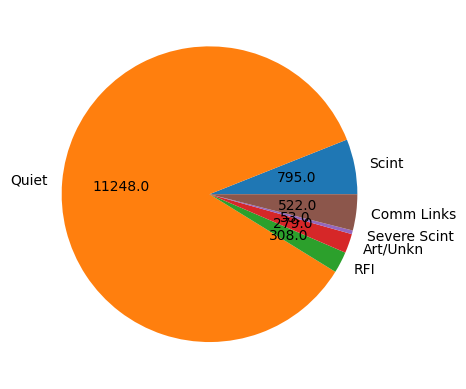

In [10]:
vals=np.array([511+127, 5962+1490, 3+1, 482+122, 169+43, 2423+605, 54+13])
vals=np.array([209+52, 5108+1277, 0, 59+15, 110+28, 2156+539, 54+13])
vals=np.array([166+92+231+104+28+13+129+32, 6200+2768+443+205+591+161+614+266, 64+10+8+0+140+86, 143+54+20+10+16+36, 37+12+4, 375+147])
val_lab=["Scint", "Quiet", "RFI", "Art/Unkn", "Severe Scint", "Comm Links"]


def absolute_value(val):
    a  = np.round(val/100.*vals.sum(), 0)
    return a

fig, ax = plt.subplots()
ax.pie(vals, labels=val_lab, autopct=absolute_value)

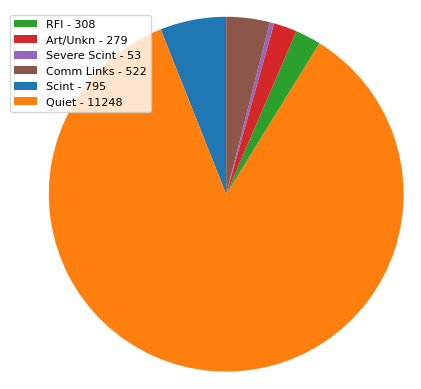

In [11]:
patches, texts = plt.pie(vals, startangle=90, radius=1.2)
labels = ['{0} - {1}'.format(i,j) for i,j in zip(val_lab, vals)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='upper left', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

#plt.savefig('../manuscript/piechart.png', dpi=300, bbox_inches='tight')

# Fit models

In [14]:
version="9" # what does this mean?
#4 multi class with severe scint
#5 multi class with psd features 80/20 split
#6 mc w/o psd features combined art and unknown. 70/30 split
#7 mc w/o psd plus sever scint class plus RFI metric
#8 with more rfi samples
#9 w/ seperate RFI classes (2 is RFI, 5 is downlink RFI)

rf_model=rf_model_train(X_train, y_train)
xgb_model=xgb_model_train(X_train, y_train,version)
svc_model=svc_model_train(X_train, y_train)

for model in [rf_model,xgb_model, svc_model]: # xgb_model,
    #--- test model
    y_pred = model.predict(X_test)

    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import precision_recall_fscore_support
    print("\nConfusion matrix")
    print(confusion_matrix(y_test, y_pred))
    y = y[~np.isnan(X).any(axis=1)]
    X = X[~np.isnan(X).any(axis=1)]
    print(X.shape, y.shape)
    print("\nResult")
    print(classification_report(y_test, y_pred))

    print(precision_recall_fscore_support(y_test, y_pred))


Best: 0.858771 using {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'auto', 'clf__n_estimators': 100}
      0.853482 (0.063881) with: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'auto', 'clf__n_estimators': 10}
      0.858771 (0.056620) with: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'auto', 'clf__n_estimators': 100}
      0.853482 (0.063881) with: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__n_estimators': 10}
      0.858771 (0.056620) with: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__n_estimators': 100}
      0.853482 (0.063881) with: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__n_estimators': 10}
      0.858771 (0.056620) with: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__n_estimators': 100}
      0.849240 (0.070532) with: {'clf__class_weight': 

In [9]:
labels

['Scint', 'Quiet', 'RFI', 'Artifact/Unknown', 'Severe Scint']

# plot to compare ML model performance

In [148]:
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb=xgb_model.predict(X_test) 
y_pred_svc=svc_model.predict(X_test)

from sklearn.metrics import confusion_matrix
def metrics_confusion(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    return TPR, FPR, ACC

# need to do this for L1 and L2?

met_li=[]
for name,y_metric in zip(["RF", "XGB", "SVC"],[y_pred_rf, y_pred_xgb, y_pred_svc, ]):
    precision, recall, fscore, support=precision_recall_fscore_support(y_test, y_metric)
    print(fscore)
    precision_w, recall_w, fscore_w, support=precision_recall_fscore_support(y_test, y_metric, average="weighted")
    print(fscore_w)
    met_li+=[np.array([[name, "Weighted Average", "Precision", precision_w],
                       [name, "Weighted Average","Recall", recall_w], 
                       [name, "Weighted Average","F1", fscore_w],
                       [name, "Scintillation Class", "Precision", precision[0]],
                       [name, "Scintillation Class","Recall", recall[0]], 
                       [name, "Scintillation Class","F1", fscore[0]],
                       [name, "RFI Class", "Precision", precision[2]],
                       [name, "RFI Class","Recall", recall[2]], 
                       [name, "RFI Class","F1", fscore[2]],
                       [name, "Comms Class", "Precision", precision[5]],
                       [name, "Comms Class","Recall", recall[5]], 
                       [name, "Comms Class","F1", fscore[5]]])]

    cm=confusion_matrix(y_test, y_metric)
    TPR, FPR, ACC=metrics_confusion(cm)
    print(TPR, FPR, ACC)

df_met=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Class", "Metric", "Score"])
df_met["Score"]=df_met.Score.astype(np.float16)

[0.59196617 0.95057803 0.27642276 0.14035088 0.64       0.83086053]
0.8871414758009694
[0.58091286 0.96735294 0.17708333 0.08       0.66666667 0.95238095] [0.02450067 0.38758389 0.0025641  0.00154004 0.00125502 0.01299039] [0.9517017  0.91441441 0.97772773 0.97547548 0.99774775 0.98573574]
[0.61412151 0.94216362 0.4921466  0.20408163 0.57142857 0.82798834]
0.8877840984155521
[0.77593361 0.92470588 0.48958333 0.15       0.66666667 0.96598639] [0.0482024  0.21812081 0.01230769 0.00821355 0.00200803 0.01402962] [0.94119119 0.9034034  0.97572573 0.97072072 0.996997   0.98523524]
[0.44811321 0.94304978 0.34328358 0.192      0.2        0.75471698]
0.8708366234076031
[0.39419087 0.96676471 0.23958333 0.12       0.16666667 0.81632653] [0.02343542 0.47651007 0.00384615 0.00333676 0.00150602 0.01325019] [0.94144144 0.90065065 0.97797798 0.97472472 0.995996   0.98048048]


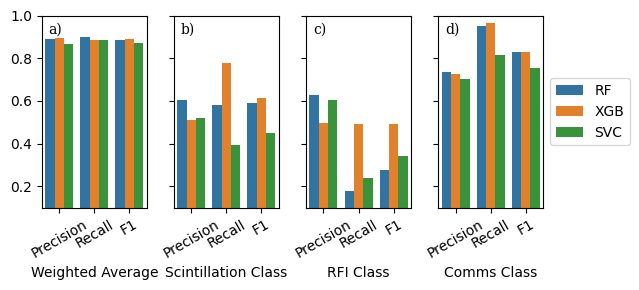

In [151]:
import seaborn as sns

fig,ax=plt.subplots(1,4, sharey=True, figsize=(6.5,3))
for i,class_ in enumerate(["Weighted Average","Scintillation Class","RFI Class", "Comms Class"]):
    sns.barplot(df_met[df_met.Class==class_], x="Metric" , y="Score", hue="Model", ax=ax[i]).set(
    xlabel=class_, 
    ylabel=None
)
    #ax[i].legend(loc='upper left',ncol=3, title=class_)
    ax[i].legend_.remove()
    ax[i].set_ylim([.1,1.])
    ax[i].tick_params(axis='x', labelrotation=30)
# Put a legend to the right of the current axis
ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

import string
alph_li=list(string.ascii_lowercase)
alph_li=[s + ')' for s in alph_li]
for j,label in enumerate(alph_li[:len(ax)]):
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
    ax[j].annotate(
        label,
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
fig.tight_layout()
plt.savefig("../manuscript/compare_f1_ml.png", dpi=300)

# plots to illustrate selected model performance and interpretability

In [152]:
#--- test model
y_pred = rf_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
print("\nConfusion matrix")
print(confusion_matrix(y_test, y_pred))
y = y[~np.isnan(X).any(axis=1)]
X = X[~np.isnan(X).any(axis=1)]
print(X.shape, y.shape)
print("\nResult")
print(classification_report(y_test, y_pred, target_names=labels))

print(precision_recall_fscore_support(y_test, y_pred))


Confusion matrix
[[ 140   98    0    0    1    2]
 [  49 3289    8    6    1   47]
 [   6   73   17    0    0    0]
 [  35   53    0    8    3    1]
 [   2    0    2    0    8    0]
 [   0    7    0    0    0  140]]
(18, 15) (18,)

Result
                  precision    recall  f1-score   support

           Scint       0.60      0.58      0.59       241
           Quiet       0.93      0.97      0.95      3400
             RFI       0.63      0.18      0.28        96
Artifact/Unknown       0.57      0.08      0.14       100
    Severe Scint       0.62      0.67      0.64        12
      Comms Link       0.74      0.95      0.83       147

        accuracy                           0.90      3996
       macro avg       0.68      0.57      0.57      3996
    weighted avg       0.89      0.90      0.89      3996

(array([0.60344828, 0.934375  , 0.62962963, 0.57142857, 0.61538462,
       0.73684211]), array([0.58091286, 0.96735294, 0.17708333, 0.08      , 0.66666667,
       0.95238095]), 

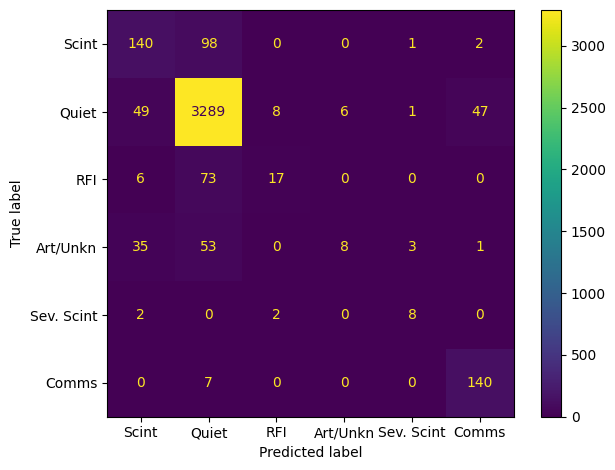

In [155]:
from sklearn.metrics import ConfusionMatrixDisplay

cm=ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["Scint","Quiet","RFI", "Art/Unkn", "Sev. Scint", "Comms"]
)
cm.figure_.tight_layout()
cm.figure_.savefig("../manuscript/conf_mat.png", dpi=300)

In [156]:
# RANDOM FOREST FEATURE IMPORTANCE
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
import time
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    xgb_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 4.880 seconds


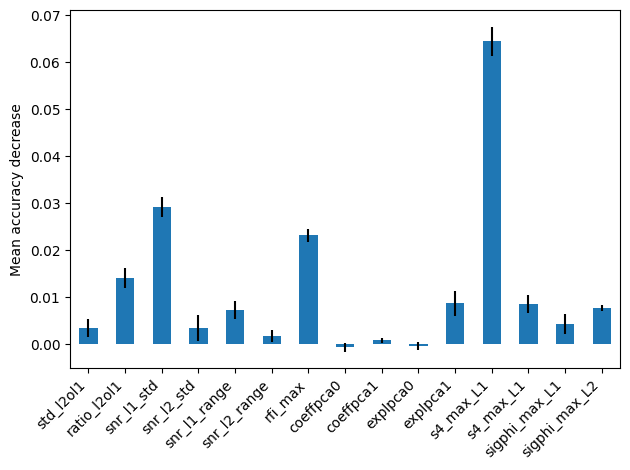

In [158]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
#ax.set_title("Feature importances using permutation on full XGB model")
ax.set_ylabel("Mean accuracy decrease")
#ax.tick_params(axis='x', labelrotation=45, right=True)
ax.set_xticklabels(feature_names, rotation=45, ha="right")
fig.tight_layout()
plt.savefig("../manuscript/feat_import.png", dpi=300)
plt.show()

# plots to compare against existing methods/thresholds

## (see below next section of examples)

In [6]:
np.unique(samples_test3)

array(['2022.352.128.13.01.G32.SC001_0001',
       '2022.354.149.19.01.G32.SC001_0001',
       '2023.007.149.08.01.R03.SC001_0001',
       '2023.074.129.21.01.G14.SC001_0001',
       '2023.086.119.16.02.G24.SC001_0001',
       '2023.087.128.15.02.G24.SC001_0001',
       '2023.101.124.19.01.G27.SC001_0001',
       '2023.105.149.19.01.G27.SC001_0001',
       '2023.108.126.19.01.G27.SC001_0001',
       '2023.119.117.16.01.G14.SC001_0001',
       '2023.144.103.13.01.E27.SC001_0001',
       '2023.144.103.13.02.R05.SC001_0001'], dtype=object)

# examples of model performance

In [232]:
# Test samples

#stdi2687/gnss-leo-data/figures/labeling_rfi/2023.016.135.20.01.G27.SC001_0001_features.png

sample='2023.080.124.19.02.G10.SC001_0001' #clean
#sample='2023.081.162.13.02.G05.SC001_0001'

#sample='2023.080.149.18.01.G04.SC001_0001'

#sample= '2023.057.135.20.01.G01.SC001_0001'

#sample='2023.081.162.13.02.G05.SC001_0001'
#sample='2023.080.149.18.01.G04.SC001_0001'

#sample='2023.080.149.18.01.G04.SC001_0001'
#sample='2023.081.119.03.01.G29.SC001_0001'
sample='2023.082.149.08.01.G18.SC001_0001' #phase and ampli
#sample = '2022.321.135.22.01.G24.SC001_0001' #rfi and scint
#sample='2023.080.149.18.01.G04.SC001_0001' #strong scint
#sample='2022.321.127.04.01.G09.SC001_0001' #strong scint/rfi
#sample='2023.066.133.20.01.G10.SC001_0001' #rfi
#sample='2023.100.143.00.01.G01.SC001_0001'
sample = '2023.119.135.18.01.G27.SC001_0001' # L2 rfi
#sample = '2022.336.163.11.01.G18.SC001_0001' #L1 rfi
#sample='2023.143.169.18.01.E25.SC001_0001'
#2022.325.120.19.01.G23.SC001_0001 Scint and RFI
#'2023.055.141.19.01.G29.SC001_0001' RFI
sample=np.unique(samples_test3)[11]

feature_pkl='../data/data/feature_sets/%s.pkl' %sample
fn='/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/%s/scnPhs_%s.0001_nc'%(sample[:8],sample)
lv1=load_leo(fn)
fn='/media/datastore/mirror/spwxdp/repro4/spire/level2/scnLv2/%s/scnLv2_%s.0001_nc'%(sample[:8],sample)
lv2=load_leo(fn)

#plot_leo(sample, sp, lv2)
#fdf=extract_fs(lv1,lv2)
#fdf['sample']=len(fdf)*[sample]
fdf=pd.read_pickle(feature_pkl)
fdf['sample']=len(fdf)*[sample]

In [8]:
# If need to load existing model
'''
version="9"
from joblib import dump, load
rf_model=load( '../models/%s_rf-model.joblib' %version)
'''

In [233]:
X, y, feature_names, fs_dict=df_2_Xy(fdf)
#--- test model
y_pred = xgb_model.predict(X)
print(y_pred)
#print(y)
# map downlink labels to Comms link
label_df=pd.read_pickle('../data/converted_labels_comms.pkl')
if sample in label_df.Filename.values:
    y=class_map_RFI(y)
    
y_true=y
print(y_true)


[1 1 1 1 2 2 1 1 1 1]
[1. 1. 1. 2. 2. 2. 1. 1. 1. 1.]


In [221]:
from matplotlib.patches import Rectangle
def plot_leo_ml_multi(sample, ds, lv2, y_pred, y_true, times, labels, plot_f=False):

    c=299792458 #m/s
    #iono_free=((ds.scnfreq1**2)*(c/ds['exL1'])-(ds.scnfreq2**2)*(c/ds['exL2']))/(ds.scnfreq1**2-ds.scnfreq2**2)
    
    #ku=40.3*1e16
    #dTEC=(ds['exL2']-ds['exL1'])/(ku*(1/ds.scnfreq1**2-1/ds.scnfreq2**2))
    fig,ax=plt.subplots(6, figsize=(6.5,6),sharex=True)
    ax[0].set_title(sample)
    init_time=(ds['caL1Snr'].time+ds.startTime)[0]
    for freq,snr,color in zip([1,2],['caL1Snr','pL2Snr'],['#1b9e77','#d95f02']): 
        ax[0].plot(ds[snr].time+ds.startTime-init_time, ds[snr].values, alpha=.5, color=color, label='L%s'%freq)
        ax[0].set_ylabel('SNR' "\n" '(v/v)')

        ax[1].plot(lv2['s4_L%s'%freq].time+lv2.startTime-init_time, lv2['s4_L%s'%freq].values, color=color, label='L%s'%freq)
        ax[1].set_ylabel('S4')
        
        #ax[1].plot(ds['raw_exL%s'%freq].time, ds['raw_exL%s'%freq].values, color=color, label='L%s'%freq)
        #ax[1].set_ylabel(r'$\delta \phi$ (cycles)')
        #ax[4].plot(lv2['elevation'].time+lv2.startTime, lv2['elevation'].values, color='black')
        ax[4].plot(ds['occheight'].time+ds.startTime-init_time, ds['occheight'].values, color='black')
        #ax[4].set_ylabel('elevation')
        ax[4].set_ylabel('Occ. Ht (km)')
        ax2=ax[4].twinx()
        #ax2.plot(ds['occheight'].time+ds.startTime, ds['occheight'].values, color='tab:orange')
        #ax2.set_ylabel('occ height', color='tab:orange')
        ax2.plot(ds['RFI'].orbtime-ds['RFI'].orbtime[0]+ds.startTime-init_time, ds['RFI'].values, color='tab:orange')
        ax2.set_ylabel('RFI Index', color='tab:orange')
        #ax2.set_ylim([0,.1])
            
        ax[2].plot(ds['exL%s'%freq].time+ds.startTime-init_time, ds['exL%s'%freq].values, color=color, label='L%s'%freq)
        ax[2].set_ylabel(r'$\delta \phi$' "\n" '(m)')

        ax[3].plot(lv2['sigma_phi_L%s'%freq].time+lv2.startTime-init_time, lv2['sigma_phi_L%s'%freq].values, color=color)
        ax[3].set_ylabel(r'$\sigma \phi$' "\n" '(m)')
    #ax[3].plot(dTEC.time, dTEC.values)
    
    #ax[3].set_ylabel(r'$\Delta TEC$' "\n" '(TECU)')
    
    #ax[4].plot(iono_free.time, iono_free.values)
    #ax[4].set_ylabel('iono-free' "\n" '(m)')
    ax[1].legend(ncol=2, loc='upper right')
    '''
    ## plot ml results
    df=pd.read_pickle('/home/kawu4468-copy/data_mat/spire_iq/rf_ml_ro.pkl')
    colors=['#e7298a','#d95f02','#7570b3','#1b9e77','#1b9e77','#66a61e','#e6ab02'] ##1b9e77
    labels=['scint', 'OA', 'dual int', 'quiet', 'quiet', 'l1 int', 'l2 int']
    fn_arr='scnPhs_%s.0001_ex.mat' %sample
    df=df[df.file==fn_arr]
    print(df['sample'])
    print(df.y_pred)
    [ax[5].add_patch(Rectangle((ds.time.min()+i*15, 0), 15, 1, alpha=.75, color= ,  label=labels[y-1])) for i, y in list(zip(df['sample'], df.y_pred))]
    '''
    
    for valz, labz, colz in zip (np.arange(6),labels,['#e41a1c','white','#4daf4a','#984ea3','#ff7f00','#ffff33']): #377eb8
        #[ax[5].add_patch(Rectangle((i, 0), 15, 1, alpha=1, label='No Scint', color="white")) for i in times[y_pred==0]]
        [ax[5].axvline(i-init_time) for i in times]
        [ax[5].add_patch(Rectangle((i-init_time, 0), 15, .5, alpha=.75, label=labz, color=colz)) for i in times[y_pred==valz]]
        [ax[5].add_patch(Rectangle((i-init_time, .5), 15, 1, alpha=.75, label=labz, color=colz)) for i in times[y_true==valz]]
    ax[5].axhline(0.5)
    handles,labels_=ax[5].get_legend_handles_labels() #get existing legend item handles and labels
    by_label = dict(zip(labels_, handles))
    ax[5].legend(by_label.values(), by_label.keys(), ncol=4, loc='lower left')
    ax[5].get_yaxis().set_ticks([])
    ax[5].set_ylabel('Pred Label')

    ax[5].set_xlim([times.min()-init_time, times.max()-init_time])
    ax[5].set_xlabel('Time (s)', loc="left")
    #ax[5].xaxis.set_label_position("left")

    import string
    alph_li=list(string.ascii_lowercase)
    alph_li=[s + ')' for s in alph_li]
    for j,label in enumerate(alph_li[:(len(ax)-1)]):
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
        ax[j].annotate(
            label,
            xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.5, -0.5), textcoords='offset fontsize',
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    ax[5].annotate(
            'f-a)',
            xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.5, -0.5), textcoords='offset fontsize',
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    ax[5].annotate(
            'f-b)',
            xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.5, -2.5), textcoords='offset fontsize',
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    
    # Shrink current axis's height by 10% on the bottom
    box = ax[5].get_position()
    ax[5].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

    # Put a legend below current axis
    ax[5].legend(by_label.values(), by_label.keys(), ncol=4, loc='upper left', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True)
    fig.tight_layout()
    if plot_f:
        plt.savefig("../manuscript/%s.png" %sample, dpi=300)


/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


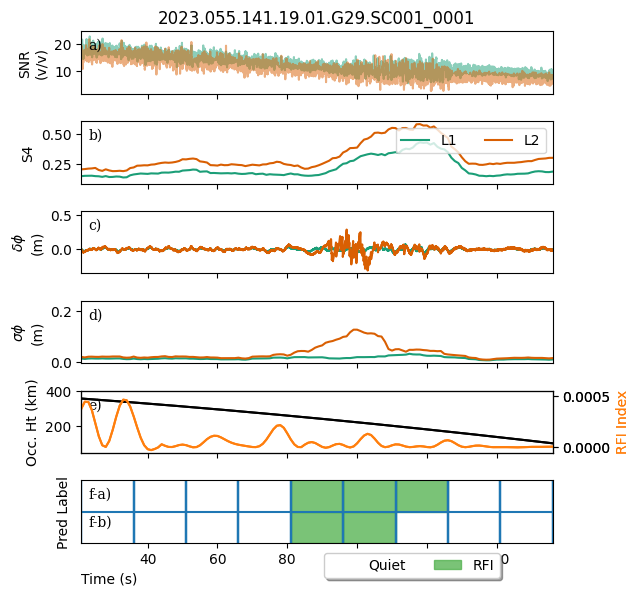

In [236]:
labels=['Scint','Quiet','RFI','Artifact/Unknown','Severe Scint', 'Comms Link']
plot_leo_ml_multi(sample, lv1, lv2, y_pred, y_true, fs_dict['time'], labels, plot_f=True)

# determine optimal thresholds

In [47]:
X_train[:,-4]>thresh

array([ True,  True,  True, ...,  True,  True,  True])

In [159]:
# Determine Optimal thresholds for S4/Sig Phi based upon training
def class_map_binary_scint(y):
    y_new=np.empty(len(y))
    y_new[y==0]=1
    y_new[y==1]=0
    y_new[y==2]=0
    y_new[y==3]=0
    y_new[y==4]=1
    y_new[y==5]=0
    return y_new
#S4
y_train_scint=class_map_binary_scint(y_train)
for thresh in np.arange(0.1,1,.1):
    y_pred_thresh_s4=np.zeros(len(X_train))
    y_pred_thresh_s4[(X_train[:,-4]>thresh)|(X_train[:,-3]>thresh)]=1
    precision, recall, fscore, support=precision_recall_fscore_support(y_train_scint, y_pred_thresh_s4)
    print(thresh, fscore)

#Sig Phi
for thresh1 in np.arange(0.03,.08,.01):
    for thresh2 in np.arange(0.01,.08,.01):
        y_pred_thresh_sig=np.zeros(len(X_train))
        y_pred_thresh_sig[(X_train[:,-2]>thresh1)|(X_train[:,-1]>thresh2)]=1
        precision, recall, fscore, support=precision_recall_fscore_support(y_train_scint, y_pred_thresh_sig)
        print(thresh1, thresh2, fscore)


0.1 [0.14012739 0.12998362]
0.2 [0.70748401 0.20980707]
0.30000000000000004 [0.85337339 0.27743804]
0.4 [0.90615166 0.31207598]
0.5 [0.93156918 0.3335277 ]
0.6 [0.94188377 0.32093664]
0.7000000000000001 [0.94688976 0.2798419 ]
0.8 [0.94840466 0.22454308]
0.9 [0.94987627 0.16330451]
0.03 0.01 [0.27514497 0.13854563]
0.03 0.02 [0.70892124 0.22377065]
0.03 0.03 [0.89638952 0.39314966]
0.03 0.04 [0.92904098 0.46053246]
0.03 0.05 [0.93620637 0.45908389]
0.03 0.060000000000000005 [0.94022363 0.4719701 ]
0.03 0.06999999999999999 [0.94176574 0.47753113]
0.03 0.08 [0.94279342 0.48113723]
0.04 0.01 [0.2753174  0.13856209]
0.04 0.02 [0.70940299 0.22399362]
0.04 0.03 [0.89674017 0.39388288]
0.04 0.04 [0.93081452 0.46641438]
0.04 0.05 [0.9421398  0.46876727]
0.04 0.060000000000000005 [0.94937838 0.47044182]
0.04 0.06999999999999999 [0.95205966 0.46780552]
0.04 0.08 [0.95267915 0.46277666]
0.05 0.01 [0.27617906 0.13864447]
0.05 0.02 [0.71017303 0.2243513 ]
0.05 0.03 [0.89744078 0.39535754]
0.05 0.04

In [ ]:
#s4 threshold=0.6
#sigma phi .07,.06

In [160]:
y_li=[]
y_pred_li=[]
y_scint_thr_li=[]
for i,sample in enumerate(np.unique(samples_test[:])):
    fn="../data/data/feature_sets/%s.pkl" %sample
    
    try:
        fdf=pd.read_pickle(fn)
        fdf['sample']=len(fdf)*[sample]
        
        X, y, feature_names, fs_dict=df_2_Xy(fdf)
        #--- test model
        y_pred = xgb_model.predict(X)

        y=class_map_binary_scint(y)
        y_pred=class_map_binary_scint(y_pred)
        y_li.append([y])
        y_pred_li.append([y_pred])

        # Scint threshold
        y_scint=np.zeros(len(X))
        #amp
        y_scint[(X[:,-4]>0.6)|(X[:,-3]>0.6)]=1
        #phse
        y_scint[(X[:,-2]>0.07)|(X[:,-1]>0.06)]=1
        y_scint_thr_li.append([y_scint])
    
        #fdf_li.append(fdf)
        #thresh_rfi_labels[fdf.rfi_max>.05]=1# .05:.91
        
    except:
        print(sample)
        continue

y_=np.concatenate(y_li, axis=1)[0]
y_pred_=np.concatenate(y_pred_li, axis=1)[0]
y_scint_=np.concatenate(y_scint_thr_li, axis=1)[0]

In [161]:
met_li=[]
for name,y_metric in zip([ "Scint Index", "ML"],[y_scint_,y_pred_]):
    precision, recall, fscore, support=precision_recall_fscore_support(y_, y_metric)
    print(fscore)
    met_li+=[np.array([[name, "Precision", precision[1]],
                       [name, "Recall", recall[1]], 
                       [name, "F1", fscore[1]]])]

    cm=confusion_matrix(y_, y_metric)
    TPR, FPR, ACC=metrics_confusion(cm)
    print(TPR, FPR, ACC)
scint_met=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Metric", "Score"])
scint_met["Score"]=scint_met.Score.astype(np.float16)

[0.92018779 0.40181612]
[0.86849628 0.72540984] [0.27459016 0.13150372] [0.85916622 0.85916622]
[0.96639022 0.62193126]
[0.94939966 0.77868852] [0.22131148 0.05060034] [0.93826831 0.93826831]


In [162]:
def class_map_binary_rfi(y):
    y_new=np.empty(len(y))
    y_new[y==0]=0
    y_new[y==1]=0
    y_new[y==2]=1
    y_new[y==3]=0
    y_new[y==4]=0
    y_new[y==5]=1
    return y_new

# RFI threshold
y_train_rfi=class_map_binary_rfi(y_train)

for thresh in np.arange(0.0001,.005,.0001):
    y_pred_thresh_rfi=np.zeros(len(X_train))
    y_pred_thresh_rfi[(X_train[:,-9]>thresh)]=1
    precision, recall, fscore, support=precision_recall_fscore_support(y_train_rfi, y_pred_thresh_rfi)
    print(thresh, fscore)

0.0001 [0.90868207 0.39285714]
0.0002 [0.93338192 0.43772424]
0.00030000000000000003 [0.94526769 0.45541023]
0.0004 [0.95301219 0.47763158]
0.0005 [0.95575326 0.48027682]
0.0006000000000000001 [0.95891695 0.48265683]
0.0007000000000000001 [0.96193812 0.49378882]
0.0008 [0.9628896  0.49162011]
0.0009000000000000001 [0.96346288 0.48943089]
0.001 [0.96380643 0.48298755]
0.0011 [0.96442871 0.48270042]
0.0012000000000000001 [0.96487771 0.47938144]
0.0013000000000000002 [0.96560908 0.48167539]
0.0014000000000000002 [0.96640259 0.48355556]
0.0015 [0.96636616 0.47755835]
0.0016 [0.96667244 0.47782805]
0.0017000000000000001 [0.96691877 0.47766636]
0.0018000000000000002 [0.96717623 0.47460757]
0.0019000000000000002 [0.96766011 0.47619048]
0.002 [0.96791659 0.4730369 ]
0.0021 [0.9681096  0.47036329]
0.0022 [0.96808327 0.4606414 ]
0.0023 [0.96781609 0.44990177]
0.0024 [0.96811628 0.45103858]
0.0025 [0.96812726 0.44776119]
0.0026 [0.9679605  0.44311377]
0.0027 [0.96803076 0.44020101]
0.0028 [0.9680

In [ ]:
#rfi metric = 0.0017
Combined: 0.0009
Just comms Downlinks: 0.0014

In [163]:
y_li=[]
y_pred_li=[]
y_rfi_thr_li=[]
for i,sample in enumerate(np.unique(samples_test)):
    fn="../data/data/feature_sets/%s.pkl" %sample
    
    try:
        fdf=pd.read_pickle(fn)
        fdf['sample']=len(fdf)*[sample]
        
        X, y, feature_names, fs_dict=df_2_Xy(fdf)

        # map downlink labels to Comms link
        label_df=pd.read_pickle('../data/converted_labels_comms.pkl')
        if sample in label_df.Filename.values:
            y=class_map_RFI(y)
            
        # rfi threshold
        y_rfi=np.zeros(len(X))
        y_rfi[fdf.rfi_max>0.0009]=1
        y_rfi_thr_li.append([y_rfi])
        #fdf_li.append(fdf)
        #thresh_rfi_labels[fdf.rfi_max>.05]=1# .05:.91

    
        #--- test model
        y_pred =xgb_model.predict(X)

        y=class_map_binary_rfi(y)
        y_pred=class_map_binary_rfi(y_pred)
        y_li.append([y])
        y_pred_li.append([y_pred])

    except:
        #print(sample)
        continue

y_=np.concatenate(y_li, axis=1)[0]
y_pred_=np.concatenate(y_pred_li, axis=1)[0]
y_rfi_=np.concatenate(y_rfi_thr_li, axis=1)[0]

In [164]:
met_li=[]
for name,y_metric in zip([ "RFI Index", "ML"],[y_rfi_,y_pred_]):
    precision, recall, fscore, support=precision_recall_fscore_support(y_, y_metric)
    print(fscore)
    met_li+=[np.array([[name, "Precision", precision[1]],
                       [name, "Recall", recall[1]], 
                       [name, "F1", fscore[1]]])]

    cm=confusion_matrix(y_, y_metric)
    TPR, FPR, ACC=metrics_confusion(cm)
    print(TPR, FPR, ACC)
rfi_met=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Metric", "Score"])
rfi_met["Score"]=rfi_met.Score.astype(np.float16)

[0.96856737 0.50374065]
[0.96780303 0.51010101] [0.48989899 0.03219697] [0.94087938 0.94087938]
[0.98434288 0.75794621]
[0.98232323 0.78282828] [0.21717172 0.01767677] [0.97058824 0.97058824]


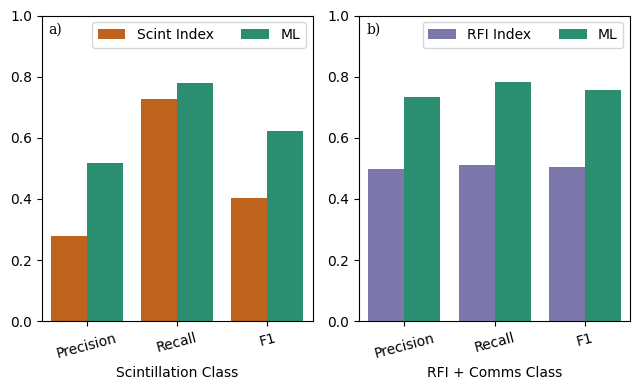

In [166]:
import seaborn as sns

palette = {
    'ML': '#1b9e77',
    'Scint Index': '#d95f02',
    'RFI Index': '#7570b3',
}

fig,axes=plt.subplots(1,2,  figsize=(6.5,4))
for i,(name,df) in enumerate(zip(['Scintillation Class', 'RFI + Comms Class'],[scint_met, rfi_met])):
    sns.barplot(df, x="Metric", y="Score", hue="Model", palette=palette, ax=axes[i]).set(
    xlabel=name, 
    ylabel=None
)
    axes[i].legend(loc='upper right',ncol=3)
    axes[i].tick_params(axis='x', labelrotation=15)
    axes[i].set_ylim([.0,1.])

import string
alph_li=list(string.ascii_lowercase)
alph_li=[s + ')' for s in alph_li]
for j,label in enumerate(alph_li[:len(axes)]):
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
    axes[j].annotate(
        label,
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
fig.tight_layout()
plt.savefig("../manuscript/compare_f1_thresh.png", dpi=300)

# Benchmark Test data against Ann's

In [35]:
ann_df=pd.read_excel('../data/labeled_profile_list_Ann.xlsx')

In [11]:
ann_df

,Unnamed: 0,Amplitude Scin. (Flag0),RFI Communication (Flag2),RFI flag (Flag3),RFI flag (Flag 4),RFI Flag (Flag 5),low SNR (Flag 6)
0,2023.144.103.01.01.E33.SC001_0001,NaN,NaN,NaN,NaN,NaN,V
1,2023.144.103.01.01.G10.SC001_0001,NaN,NaN,V,NaN,NaN,NaN
2,2023.144.103.01.01.G25.SC001_0001,NaN,NaN,NaN,NaN,NaN,NaN
3,2023.144.103.01.01.G26.SC001_0001,NaN,NaN,NaN,NaN,NaN,NaN
4,2023.144.103.01.01.G27.SC001_0001,NaN,NaN,NaN,NaN,NaN,V
...,...,...,...,...,...,...,...
692,2023.096.163.12.02.G01.SC001_0001,NaN,V,NaN,NaN,NaN,NaN
693,2023.096.163.12.01.G29.SC001_0001,NaN,V,NaN,NaN,NaN,NaN
694,2023.102.163.23.01.G24.SC001_0001,NaN,V,NaN,NaN,NaN,NaN
695,2023.102.163.23.01.G24.SC001_0001,NaN,V,NaN,NaN,NaN,NaN


In [72]:
len(np.unique(samples_test))

198

In [56]:
unique, counts = np.unique(y_test, return_counts=True)
count_dict=dict(zip(unique, counts))
print(count_dict)

{0.0: 230, 1.0: 3123, 2.0: 173, 3.0: 147}


In [61]:
ann_scint_labels=np.zeros(len(samples_test))
ml_scint_labels=np.zeros(len(samples_test))
real_scint_labels=np.zeros(len(samples_test))
ann_rfi_labels=np.zeros(len(samples_test))
ml_rfi_labels=np.zeros(len(samples_test))
real_rfi_labels=np.zeros(len(samples_test))
s4_scint_labels=np.zeros(len(samples_test))
sig_scint_labels=np.zeros(len(samples_test))
thresh_rfi_labels=np.zeros(len(samples_test))

for i,sample in enumerate(samples_test):
    fn="../data/data/feature_sets/%s.pkl" %sample
    
    try:
        fdf=pd.read_pickle(fn)
        fdf['sample']=len(fdf)*[sample]
        #print(fdf)
        X, y, feature_names, fs_dict=df_2_Xy(fdf)
        #--- test model
        y_pred = rf_model.predict(X)
        
        #scint_test
        if ann_df[ann_df['Unnamed: 0']==sample].iloc[:,1:2].values[0][0]=='V':
            ann_scint_labels[i]=1
        if 0 in y_pred:
            ml_scint_labels[i]=1
        if 0 in y:
            real_scint_labels[i]=1

        #threshold
        y_pred_thresh_s4=np.zeros(len(X))
        y_pred_thresh_s4[(X[:,-4]>0.6)|(X[:,-3]>0.6)]=1
        if 1 in y_pred_thresh_s4:
            s4_scint_labels[i]=1

        y_pred_thresh_sig=np.zeros(len(X))
        y_pred_thresh_sig[(X[:,-2]>0.07)|(X[:,-1]>0.06)]=1
        if 1 in y_pred_thresh_sig:
            s4_scint_labels[i]=1

        #RFI_test
        if 'V' in ann_df[ann_df['Unnamed: 0']==sample].iloc[:,2:].values[0]:
            ann_rfi_labels[i]=1
        if 2 in y_pred:
            ml_rfi_labels[i]=1
        if 2 in y:
            real_rfi_labels[i]=1
        if fdf.rfi_max.max()>.05:# .05:.91
            thresh_rfi_labels[i]=1
    except:
        continue
    

In [54]:
from sklearn.metrics import f1_score
print(f1_score(ann_rfi_labels, real_rfi_labels))
print(f1_score(ml_rfi_labels, real_rfi_labels))
print(f1_score(thresh_rfi_labels, real_rfi_labels))

print(f1_score(ann_scint_labels, real_scint_labels))
print(f1_score(ml_scint_labels, real_scint_labels))
print(f1_score(s4_scint_labels, real_scint_labels))
#print(f1_score(sig_scint_labels, real_scint_labels))

0.26514486391571557
0.671604938271605
0.7849162011173186
0.6509495743287492
0.6794612794612794
0.5718849840255591


In [45]:
from sklearn.metrics import f1_score
print(f1_score(ann_rfi_labels, real_rfi_labels))
print(f1_score(ml_rfi_labels, real_rfi_labels))
print(f1_score(thresh_rfi_labels, real_rfi_labels))

print(f1_score(ann_scint_labels, real_scint_labels))
print(f1_score(ml_scint_labels, real_scint_labels))
print(f1_score(s4_scint_labels, real_scint_labels))
#print(f1_score(sig_scint_labels, real_scint_labels))

0.26514486391571557
0.7137637028014616
0.7849162011173186
0.6509495743287492
0.6957431960921144
0.5718849840255591


In [46]:
# Make a plot to compare model testing performance with thresholds

from sklearn.metrics import confusion_matrix
def metrics_confusion(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    return TPR, FPR, ACC

# SCINTILLATION

met_li=[]
for name,y_metric in zip([ "Threshold", "Chang24", "ML"],[s4_scint_labels,ann_scint_labels, ml_scint_labels]):
    precision, recall, fscore, support=precision_recall_fscore_support(real_scint_labels, y_metric)
    print(fscore)
    met_li+=[np.array([[name, "Precision", precision[1]],
                       [name, "Recall", recall[1]], 
                       [name, "F1", fscore[1]]])]

    cm=confusion_matrix(y_test, y_metric)
    TPR, FPR, ACC=metrics_confusion(cm)
    print(TPR, FPR, ACC)
scint_met=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Metric", "Score"])
scint_met["Score"]=df_met.Score.astype(np.float16)

# RFI

met_li=[]
for name,y_metric in zip([ "Threshold", "Chang24", "ML"],[thresh_rfi_labels,ann_rfi_labels, ml_rfi_labels]):
    precision, recall, fscore, support=precision_recall_fscore_support(real_rfi_labels, y_metric)
    print(fscore)
    met_li+=[np.array([[name, "Precision", precision[1]],
                       [name, "Recall", recall[1]], 
                       [name, "F1", fscore[1]]])]

    cm=confusion_matrix(y_test, y_metric)
    TPR, FPR, ACC=metrics_confusion(cm)
    print(TPR, FPR, ACC)

rfi_met=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Metric", "Score"])
rfi_met["Score"]=df_met.Score.astype(np.float16)


[0.77860388 0.57188498]
[0.34347826 0.246878   0.         0.        ] [0.71478362 0.65818182 0.         0.        ] [0.28886469 0.26109447 0.95289954 0.95997822]
[0.75163094 0.65094957]
[0.13478261 0.46013449 0.         0.        ] [0.56898054 0.44727273 0.         0.        ] [0.41246937 0.47399946 0.95289954 0.95997822]
[0.80535714 0.6957432 ]
[0.17826087 0.38488633 0.         0.        ] [0.62067964 0.53272727 0.         0.        ] [0.36673019 0.39722298 0.95289954 0.95997822]
[0.97677225 0.7849162 ]
[0.94347826 0.06308037 0.         0.        ] [0.89805402 0.30363636 0.         0.        ] [0.15464198 0.15790907 0.95289954 0.95997822]
[0.66969219 0.26514486]
[0.87826087 0.52161383 0.         0.        ] [0.44873657 0.54       0.         0.        ] [0.57173972 0.51238769 0.95289954 0.95997822]
[0.96398467 0.7137637 ]
[0.86086957 0.08581492 0.         0.        ] [0.87307581 0.36545455 0.         0.        ] [0.1728832  0.16798258 0.95289954 0.95997822]


/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/

In [29]:
# compare scintillation detection vs amp/phase thresholds
# 

def class_map_binary_scint(y):
    y_new=np.empty(len(y))
    y_new[y==0]=1
    y_new[y==1]=0
    y_new[y==2]=0
    y_new[y==3]=0
    y_new[y==4]=1
    return y_new
y_li=[]
y_pred_li=[]
y_scint_thr_li=[]
for i,sample in enumerate(samples_test[:]):
    fn="../data/feature_sets/%s.pkl" %sample
    
    try:
        fdf=pd.read_pickle(fn)
        fdf['sample']=len(fdf)*[sample]
        
        X, y, feature_names, fs_dict=df_2_Xy(fdf)
        #--- test model
        y_pred = rf_model.predict(X)

        y=class_map_binary_scint(y)
        y_pred=class_map_binary_scint(y_pred)
        y_li.append([y])
        y_pred_li.append([y_pred])

        # Scint threshold
        y_scint=np.zeros(len(X))
        #amp
        y_scint[(X[:,-4]>0.6)|(X[:,-3]>0.6)]=1
        #phse
        y_scint[(X[:,-2]>0.07)|(X[:,-1]>0.06)]=1
        y_scint_thr_li.append([y_scint])
    
        #fdf_li.append(fdf)
        #thresh_rfi_labels[fdf.rfi_max>.05]=1# .05:.91
        
    except:
        print(sample)
        continue

y_=np.concatenate(y_li, axis=1)[0]
y_pred_=np.concatenate(y_pred_li, axis=1)[0]
y_scint_=np.concatenate(y_scint_thr_li, axis=1)[0]


In [30]:
met_li=[]
for name,y_metric in zip([ "Scint Index", "ML"],[y_scint_,y_pred_]):
    precision, recall, fscore, support=precision_recall_fscore_support(y_, y_metric)
    print(fscore)
    met_li+=[np.array([[name, "Precision", precision[1]],
                       [name, "Recall", recall[1]], 
                       [name, "F1", fscore[1]]])]

    cm=confusion_matrix(y_, y_metric)
    TPR, FPR, ACC=metrics_confusion(cm)
    print(TPR, FPR, ACC)
scint_met=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Metric", "Score"])
scint_met["Score"]=scint_met.Score.astype(np.float16)

[0.95473424 0.45657857]
[0.92926217 0.68051948] [0.31948052 0.07073783] [0.91642969 0.91642969]
[0.98410573 0.65129781]
[0.99240188 0.55036075] [0.44963925 0.00759812] [0.96959726 0.96959726]


In [31]:
# compare rfi detection vs rfi thresholds
# 

def class_map_binary_rfi(y):
    y_new=np.empty(len(y))
    y_new[y==0]=0
    y_new[y==1]=0
    y_new[y==2]=1
    y_new[y==3]=0
    y_new[y==4]=0
    return y_new
y_li=[]
y_pred_li=[]
y_rfi_thr_li=[]
for i,sample in enumerate(samples_test):
    fn="../data/feature_sets/%s.pkl" %sample
    
    try:
        fdf=pd.read_pickle(fn)
        fdf['sample']=len(fdf)*[sample]
        
        X, y, feature_names, fs_dict=df_2_Xy(fdf)

        # rfi threshold
        y_rfi=np.zeros(len(X))
        y_rfi[fdf.rfi_max>.05]=1
        y_rfi_thr_li.append([y_rfi])
        #fdf_li.append(fdf)
        #thresh_rfi_labels[fdf.rfi_max>.05]=1# .05:.91

    
        #--- test model
        y_pred =rf_model.predict(X)

        y=class_map_binary_rfi(y)
        y_pred=class_map_binary_rfi(y_pred)
        y_li.append([y])
        y_pred_li.append([y_pred])

        
        
    except:
        #print(sample)
        continue

y_=np.concatenate(y_li, axis=1)[0]
y_pred_=np.concatenate(y_pred_li, axis=1)[0]
y_rfi_=np.concatenate(y_rfi_thr_li, axis=1)[0]
'''
met_li=[]
for name,y_metric in zip([ "RFI Index", "ML"],[y_rfi_,y_pred_]):
    precision, recall, fscore, support=precision_recall_fscore_support(y_, y_metric)
    print(fscore)
    met_li+=[np.array([[name, "Precision", precision[1]],
                       [name, "Recall", recall[1]], 
                       [name, "F1", fscore[1]]])]

    cm=confusion_matrix(y_, y_metric)
    TPR, FPR, ACC=metrics_confusion(cm)
    print(TPR, FPR, ACC)
rfi_met=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Metric", "Score"])
rfi_met["Score"]=rfi_met.Score.astype(np.float16)
'''

'\nmet_li=[]\nfor name,y_metric in zip([ "RFI Index", "ML"],[y_rfi_,y_pred_]):\n    precision, recall, fscore, support=precision_recall_fscore_support(y_, y_metric)\n    print(fscore)\n    met_li+=[np.array([[name, "Precision", precision[1]],\n                       [name, "Recall", recall[1]], \n                       [name, "F1", fscore[1]]])]\n\n    cm=confusion_matrix(y_, y_metric)\n    TPR, FPR, ACC=metrics_confusion(cm)\n    print(TPR, FPR, ACC)\nrfi_met=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Metric", "Score"])\nrfi_met["Score"]=rfi_met.Score.astype(np.float16)\n'

In [32]:
met_li=[]
for name,y_metric in zip([ "RFI Index", "ML"],[y_rfi_,y_pred_]):
    precision, recall, fscore, support=precision_recall_fscore_support(y_, y_metric)
    print(fscore)
    met_li+=[np.array([[name, "Precision", precision[1]],
                       [name, "Recall", recall[1]], 
                       [name, "F1", fscore[1]]])]

    cm=confusion_matrix(y_, y_metric)
    TPR, FPR, ACC=metrics_confusion(cm)
    print(TPR, FPR, ACC)
rfi_met=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Metric", "Score"])
rfi_met["Score"]=rfi_met.Score.astype(np.float16)

[0.98452535 0.24948875]
[0.9983581  0.14921722] [0.85078278 0.0016419 ] [0.96967594 0.96967594]
[0.99268192 0.8148631 ]
[0.9883186  0.91731898] [0.08268102 0.0116814 ] [0.98592038 0.98592038]


In [ ]:
##just for hlep
# fig,ax=plt.subplots(1,3, sharey=True, figsize=(6,3))
for i,class_ in enumerate(["Weighted Average","Scintillation Class","RFI Class"]):
    sns.barplot(df_met[df_met.Class==class_], x="Metric" , y="Score", hue="Model", ax=ax[i]).set(
    xlabel=class_, 
    ylabel=None
)
    #ax[i].legend(loc='upper left',ncol=3, title=class_)
    ax[i].legend_.remove()
    ax[i].set_ylim([.5,1.])
    ax[i].tick_params(axis='x', labelrotation=30)
# Put a legend to the right of the current axis
ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
#fig.tight_layout()
plt.savefig("../figures/manuscript/compare_f1_ml.png", dpi=300)

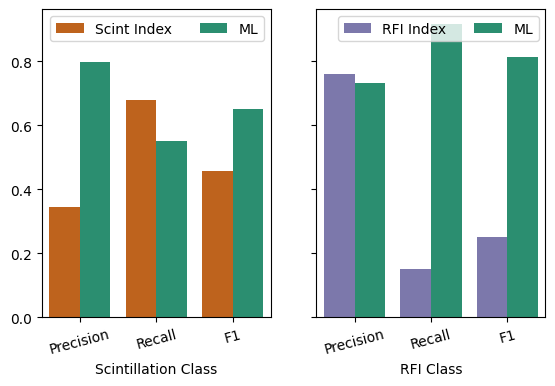

In [33]:
import seaborn as sns

palette = {
    'ML': '#1b9e77',
    'Scint Index': '#d95f02',
    'RFI Index': '#7570b3',
}

fig,axes=plt.subplots(1,2, sharey=True, figsize=(6.5,4))
for i,(name,df) in enumerate(zip(['Scintillation Class', 'RFI Class'],[scint_met, rfi_met])):
    sns.barplot(df, x="Metric", y="Score", hue="Model", palette=palette, ax=axes[i]).set(
    xlabel=name, 
    ylabel=None
)
    axes[i].legend(loc='upper right',ncol=3)
    axes[i].tick_params(axis='x', labelrotation=15)
    #ax[i].set_ylim([.5,1.09])
plt.savefig("../manuscript/compare_f1_thresh.png", dpi=300)

# Train model on entire dataset